In [1]:
import os
import matplotlib.pyplot as plt
import seaborn as sns
import autograd.numpy as np
from scipy.stats import t 
from itertools import product
import pystan

from viabel.vb import (mean_field_t_variational_family, 
                       make_stan_log_density, 
                       adagrad_optimize)
from experiments import *

sns.set_style('white')
sns.set_context('notebook', font_scale=2.5, rc={'lines.linewidth': 2})

# Eight Schools Model

For more details on this example, see:

[Practical posterior error bounds from variational objectives](https://arxiv.org/abs/1910.04102).
Jonathan H. Huggins,
Miko&#0322;aj Kasprzak,
Trevor Campbell,
Tamara Broderick.
In *Proc. of the 23rd International Conference on Artificial Intelligence and
Statistics* (AISTATS), Palermo, Italy. PMLR: Volume 108, 2020.

In [2]:
os.makedirs('../figures', exist_ok=True)

logtau_lim = [-2, 3.5]
mu_lim = [-5, 15]
theta1_lim = [-8, 22]

skip = 1 # how much to thin samples; larger values make the plots faster but let accurate 

In [3]:
def plot_sample_contours(x_samples1, y_samples1, x_samples2, y_samples2, xlabel, ylabel, xlim, ylim, 
                    cmap1, cmap2, savepath=None, **kwargs):
    sns.kdeplot(x_samples1, y_samples1, cmap=cmap1, **kwargs)
    sns.kdeplot(x_samples2, y_samples2, cmap=cmap2, **kwargs)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.xlim(xlim)
    plt.ylim(ylim)
    plt.xticks([])
    plt.yticks([])
    if savepath is not None:
        plt.savefig(savepath, bbox_inches='tight')
    plt.show()
    
def plot_sample_and_density_contours(x_samples, y_samples, logdensity, xlabel, ylabel, xlim, ylim, 
                    cmap_samples, cmap_density, savepath=None, **kwargs):
    sns.kdeplot(x_samples, y_samples, cmap=cmap_samples, **kwargs)
    x = np.linspace(*xlim, 100)
    y = np.linspace(*ylim, 100)
    X, Y = np.meshgrid(x, y)
    XY = np.concatenate([X[:,:,np.newaxis], Y[:,:,np.newaxis]], axis=2)
    Z = np.exp(logdensity(XY))
    plt.contour(X, Y, Z, cmap=cmap_density, linestyles='solid')
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.xlim(xlim)
    plt.ylim(ylim)
    plt.xticks([])
    plt.yticks([])
    if savepath is not None:
        plt.savefig(savepath, bbox_inches='tight')
    plt.show()
    
def tranform_to_theta(ncp_samples):
    ncp_samples_tranformed = ncp_samples.copy()
    ncp_samples_tranformed[2:] = (ncp_samples_tranformed[0] 
                                  + np.exp(ncp_samples_tranformed[1]) * ncp_samples_tranformed[2:])
    return ncp_samples_tranformed

def get_ncp_approx_samples(var_family, opt_param, n_samples):
    ncp_samples = var_family.sample(opt_param, n_samples).T
    return ncp_samples, tranform_to_theta(ncp_samples)

## Model compilation and ground truth sampling

Compile Stan models

In [4]:
eight_schools_cp_stan_model = pystan.StanModel(file='eight_schools_cp.stan' ,
                                               model_name='eight_schools_cp')

INFO:pystan:COMPILING THE C++ CODE FOR MODEL eight_schools_cp_b061d14b15cea7d7e6cf0b7700a8b143 NOW.


In [5]:
eight_schools_ncp_stan_model = pystan.StanModel(file='eight_schools_ncp.stan',
                                                model_name='eight_schools_ncp')

INFO:pystan:COMPILING THE C++ CODE FOR MODEL eight_schools_ncp_83f1609305e7267422b692fbee65a5db NOW.


Construct eight schools data and fit models. Note that fitting the centered parameterization model is problematic. 

In [6]:
# Data of the Eight Schools Model
J = 8
y = np.array([28.,  8., -3.,  7., -1.,  1., 18., 12.])
sigma = np.array([15., 10., 16., 11.,  9., 11., 10., 18.])
data = dict(J=J, y=y, sigma=sigma)

In [7]:
eight_schools_cp_fit = eight_schools_cp_stan_model.sampling(data=data, iter=11000, warmup=1000,
                                                            control=dict(adapt_delta=.99))

In [8]:
eight_schools_ncp_fit = eight_schools_ncp_stan_model.sampling(data=data, iter=32000, warmup=2000, thin=3,
                                                              control=dict(adapt_delta=.95))

In [9]:
eight_schools_ncp_fit

Inference for Stan model: eight_schools_ncp_83f1609305e7267422b692fbee65a5db.
4 chains, each with iter=32000; warmup=2000; thin=3; 
post-warmup draws per chain=10000, total post-warmup draws=40000.

                 mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
mu               4.36    0.02   3.33  -2.18   2.13   4.38   6.61  10.85  39393    1.0
tau              3.57    0.02   3.16   0.13   1.27   2.76   4.95  11.65  37561    1.0
theta_tilde[1]   0.31  4.9e-3   0.99  -1.65  -0.35   0.33   0.98   2.22  40588    1.0
theta_tilde[2]    0.1  4.7e-3   0.94  -1.75  -0.52   0.11   0.72   1.94  40592    1.0
theta_tilde[3]  -0.08  4.9e-3   0.97  -1.97  -0.74  -0.09   0.56   1.84  39561    1.0
theta_tilde[4]   0.06  4.7e-3   0.95  -1.81  -0.57   0.06   0.68   1.91  40546    1.0
theta_tilde[5]  -0.16  4.6e-3   0.93  -1.98  -0.79  -0.17   0.45   1.71  40995    1.0
theta_tilde[6]  -0.07  4.7e-3   0.95  -1.92  -0.71  -0.07   0.56   1.79  40688    1.0
theta_tilde[7]   0.36  4.8e

Record relevant information from both models and use samples from non-centered model as ground truth

In [10]:
# number of parameters and parameter names in centered model
n_params_cp = len(eight_schools_cp_fit.constrained_param_names())
param_names_cp = ['mu', 'log_tau'] + eight_schools_cp_fit.flatnames[2:n_params_cp]

# number of parameters and parameter names in non-centered model
n_params_ncp = len(eight_schools_ncp_fit.constrained_param_names())
param_names_ncp = ['mu', 'log_tau'] + eight_schools_ncp_fit.flatnames[2:n_params_ncp]
param_names_ncp_transformed = ['mu', 'log_tau'] + eight_schools_ncp_fit.flatnames[n_params_ncp:]

# the centered and tranformed non-centered parameters should be the same
np.testing.assert_array_equal(param_names_cp, param_names_ncp_transformed)

# construct matrix of samples (both original and transformed) from non-centered model 
samples_ncp_df = eight_schools_ncp_fit.to_dataframe(pars=eight_schools_ncp_fit.flatnames)
samples_ncp_df['log_tau'] = np.log(samples_ncp_df['tau'])
samples_ncp = samples_ncp_df.loc[:,param_names_ncp].values.T
samples_ncp_transformed = samples_ncp_df.loc[:,param_names_ncp_transformed].values.T

# use samples from non-centered model for ground true mean and covariance
true_mean_ncp = np.mean(samples_ncp, axis=1)
true_cov_ncp = np.cov(samples_ncp)
true_mean_ncp_tranformed = np.mean(samples_ncp_transformed, axis=1)
true_cov_ncp_tranformed = np.cov(samples_ncp_transformed)

## Variational inference for centered model (df = 40)

|--------------|
|     KLVI     |
|--------------|


Average Loss = 8.5926: 100%|██████████| 10000/10000 [00:35<00:00, 278.19it/s]


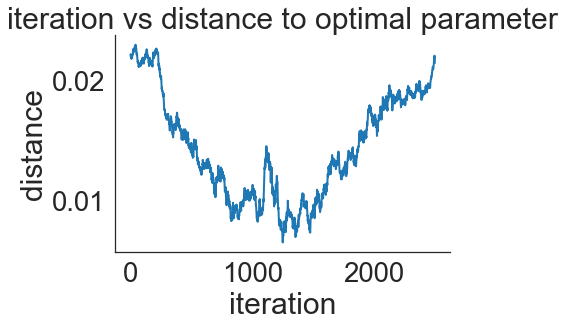

mean   = [4.22736001 1.7604565  6.92981493 5.07881533 3.50424169 4.7612786
 2.84550797 3.60332607 7.34516606 4.86878296]
stdevs = [1.80665024 0.24118027 5.1438874  4.80988553 5.1831737  4.89104254
 4.68841838 4.9128524  4.81259799 5.2607486 ]

mean error             = 1.92
stdev error            = 1.85
||cov error||_2^{1/2}  = 8.49
||true cov||_2^{1/2}   = 9.71

Computing CUBO and ELBO with 2500000 samples took 25.427 sec to run

Bounds on...
  2-Wasserstein   539
  2-divergence    11.6
  mean error      539
  stdev error     539
  sqrt cov error  766
  cov error       5.87e+05

Results with PSIS correction
----------------------------


/Users/jhuggins/Desktop/viabel/notebooks/psis.py:295: RuntimeWarning: overflow encountered in exp
  np.exp(temp, out=temp)


khat = 0.906

mean   = [4.57777306 1.52379063 7.4258065  5.15189451 3.92824258 5.12360126
 3.3088396  3.91613605 7.26239165 5.38458389]
stdevs = [2.94236316 0.46447489 5.81854365 4.92567795 5.47324865 5.07204051
 4.69491761 5.06816812 5.27044389 5.70522679]

mean error             = 1.99
stdev error            = 1.11
||cov error||_2^{1/2}  = 5.44
||true cov||_2^{1/2}   = 9.71

|---------------|
|     CHIVI     |
|---------------|


Average Loss = 9.2507: 100%|██████████| 10000/10000 [03:26<00:00, 48.41it/s]


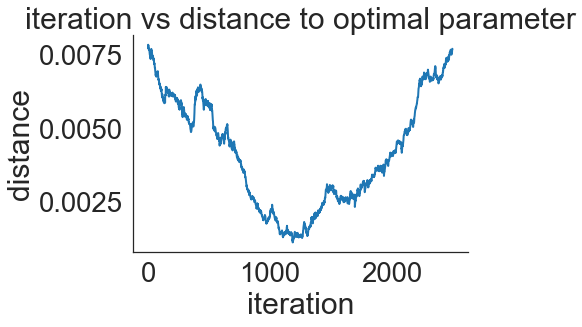

mean   = [4.35824669 0.90564602 6.14540282 4.90033529 3.87240384 4.68256218
 3.58068588 4.02877148 6.24648313 4.80902333]
stdevs = [3.13813576 1.12082881 5.68778895 4.70491692 5.3848787  4.87009875
 4.69294305 4.97663049 5.10790505 5.35422903]

mean error             = 0.102
stdev error            = 0.357
||cov error||_2^{1/2}  = 8.36
||true cov||_2^{1/2}   = 9.71

Computing CUBO and ELBO with 2500000 samples took 35.995 sec to run

Bounds on...
  2-Wasserstein   983
  2-divergence    13.8
  mean error      983
  stdev error     983
  sqrt cov error  1.39e+03
  cov error       1.94e+06

Results with PSIS correction
----------------------------


/Users/jhuggins/Desktop/viabel/notebooks/psis.py:295: RuntimeWarning: overflow encountered in exp
  np.exp(temp, out=temp)


khat = 0.875

mean   = [4.2945406  1.13366334 6.14458293 4.96726937 3.86560871 4.7748639
 3.48455288 3.85762969 6.27480276 4.7980448 ]
stdevs = [2.83968033 0.72328073 5.05298782 4.72622982 4.89457098 4.51453828
 4.37901939 4.59514297 4.76403873 5.07096007]

mean error             = 0.409
stdev error            = 1.06
||cov error||_2^{1/2}  = 5.37
||true cov||_2^{1/2}   = 9.71


In [11]:
eight_schools_cp_log_density = make_stan_log_density(eight_schools_cp_fit)
var_family_cp = mean_field_t_variational_family(n_params_cp, 40)

init_param_cp = np.concatenate([true_mean_ncp_tranformed, .5*np.log(np.diag(true_cov_ncp_tranformed))])
klvi_cp, chivi_cp, klvi_cp_results, chivi_cp_results, other_klvi_cp_results, other_chivi_cp_results = \
    run_experiment(eight_schools_cp_log_density, var_family_cp, init_param_cp, 
                   true_mean_ncp_tranformed, true_cov_ncp_tranformed, 
                   learning_rate=.01, learning_rate_end=.001,
                   n_iters=10000, bound_w2=2500000, verbose=True)

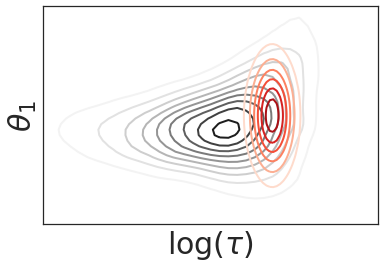

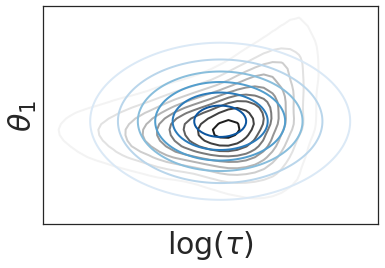

In [12]:
def cp_results_plot(other_results, method):
    if method not in ['klvi', 'chivi']:
        print('invalid method "{}"'.format(method))
        return
    cp_opt_param = other_results['opt_param']
    cp_mean, cp_log_scale = cp_opt_param[:n_params_cp], cp_opt_param[n_params_cp:]
    cp_log_density = lambda x: np.sum(t.logpdf(x, 40, cp_mean[np.newaxis,np.newaxis,1:3], 
                                               np.exp(cp_log_scale[np.newaxis,np.newaxis,1:3])), axis=-1)
    cmap2 = 'Reds' if method == 'klvi' else 'Blues'
    plot_sample_and_density_contours(
        np.log(eight_schools_ncp_fit['tau'][::skip]), eight_schools_ncp_fit['theta[1]'][::skip],
        cp_log_density, r'$\log(\tau)$', r'$\theta_1$', 
        logtau_lim, theta1_lim, 'Greys', cmap2,
        '../figures/8-schools-cp-log-tau-vs-theta1-{}.pdf'.format(method))

cp_results_plot(other_klvi_cp_results, 'klvi')
cp_results_plot(other_chivi_cp_results, 'chivi')

## Variational inference for non-centered model (df = 40)

|--------------|
|     KLVI     |
|--------------|


Average Loss = 6.8108: 100%|██████████| 5000/5000 [00:20<00:00, 243.26it/s]


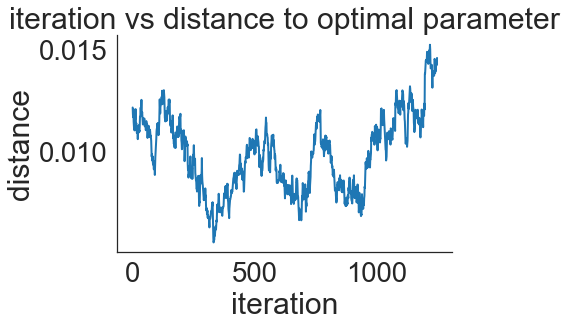

mean   = [ 4.52278999  0.80229974  0.28910281  0.08664231 -0.07788267  0.0521493
 -0.17233392 -0.07571718  0.3460842   0.06386273]
stdevs = [3.17440099 0.73040986 0.96470498 0.93606988 0.97227239 0.94551803
 0.91889553 0.93926169 0.93228648 0.97817974]

mean error             = 0.164
stdev error            = 0.458
||cov error||_2^{1/2}  = 1.26
||true cov||_2^{1/2}   = 3.34

Computing CUBO and ELBO with 2500000 samples took 35.128 sec to run

Bounds on...
  2-Wasserstein   25.3
  2-divergence    3.86
  mean error      25.3
  stdev error     25.3
  sqrt cov error  37.9
  cov error       1.44e+03

Results with PSIS correction
----------------------------


/Users/jhuggins/Desktop/viabel/notebooks/psis.py:295: RuntimeWarning: overflow encountered in exp
  np.exp(temp, out=temp)


khat = 0.649

mean   = [ 4.39907808  0.84887549  0.31843362  0.09926744 -0.08558882  0.06672637
 -0.16268364 -0.07638848  0.35978036  0.07624575]
stdevs = [3.33121629 1.06914397 0.98401813 0.93653348 0.96964897 0.94444588
 0.92894701 0.94193743 0.95946552 0.97161344]

mean error             = 0.0592
stdev error            = 0.0897
||cov error||_2^{1/2}  = 0.454
||true cov||_2^{1/2}   = 3.34

|---------------|
|     CHIVI     |
|---------------|


Average Loss = 8.2215: 100%|██████████| 5000/5000 [01:51<00:00, 44.82it/s]


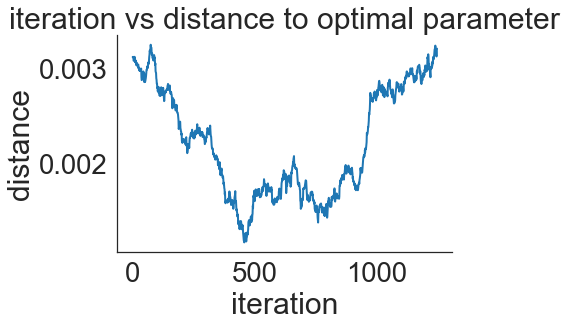

mean   = [ 4.37407172  0.93989067  0.34039089  0.09999746 -0.09406385  0.06003261
 -0.175485   -0.07886893  0.37726345  0.08150947]
stdevs = [3.33895897 1.13090551 0.99731137 0.93890686 0.96887329 0.94415424
 0.93695135 0.94636764 0.97043439 0.97655597]

mean error             = 0.141
stdev error            = 0.0307
||cov error||_2^{1/2}  = 0.948
||true cov||_2^{1/2}   = 3.34

Computing CUBO and ELBO with 2500000 samples took 25.049 sec to run

Bounds on...
  2-Wasserstein   14.5
  2-divergence    1.62
  mean error      14.5
  stdev error     14.5
  sqrt cov error  22.7
  cov error       517

Results with PSIS correction
----------------------------


/Users/jhuggins/Desktop/viabel/notebooks/psis.py:295: RuntimeWarning: overflow encountered in exp
  np.exp(temp, out=temp)


khat = 0.552

mean   = [ 4.39646073  0.80250954  0.31880989  0.09795127 -0.08298271  0.06268788
 -0.16401534 -0.07197635  0.35693051  0.07631723]
stdevs = [3.30509631 1.16315155 0.98953711 0.93797134 0.96933171 0.94409943
 0.93112845 0.94234768 0.95927977 0.97414907]

mean error             = 0.0355
stdev error            = 0.0291
||cov error||_2^{1/2}  = 0.446
||true cov||_2^{1/2}   = 3.34


In [13]:
eight_schools_ncp_log_density = make_stan_log_density(eight_schools_ncp_fit)
var_family_ncp = mean_field_t_variational_family(n_params_ncp, 40)

init_param_ncp = np.concatenate([true_mean_ncp, .5*np.log(np.diag(true_cov_ncp))])
klvi_ncp, chivi_ncp, klvi_ncp_results, chivi_ncp_results, other_klvi_ncp_results, other_chivi_ncp_results = \
    run_experiment(eight_schools_ncp_log_density, var_family_ncp, init_param_ncp, true_mean_ncp, true_cov_ncp, 
                   learning_rate=.01, learning_rate_end=.001,
                   n_iters=5000, bound_w2=2500000, verbose=True)

In [14]:
n_samples = eight_schools_ncp_fit['tau'][::skip].size
klvi_ncp_samples, klvi_ncp_samples_tranformed = \
    get_ncp_approx_samples(var_family_ncp, other_klvi_ncp_results['opt_param'], n_samples)
chivi_ncp_samples, chivi_ncp_samples_tranformed = \
    get_ncp_approx_samples(var_family_ncp, other_chivi_ncp_results['opt_param'], n_samples)

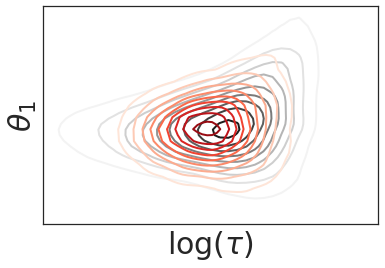

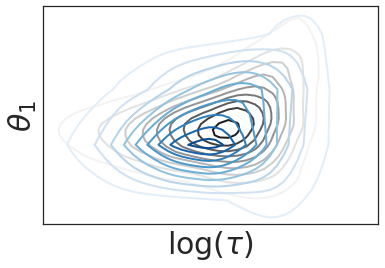

In [15]:
def plot_cp_results(ncp_samples_tranformed, method):
    if method not in ['klvi', 'chivi']:
        print('invalid method "{}"'.format(method))
        return
    cmap2 = 'Reds' if method == 'klvi' else 'Blues'
    plot_sample_contours(np.log(eight_schools_ncp_fit['tau'][::skip]), eight_schools_ncp_fit['theta[1]'][::skip], 
                         ncp_samples_tranformed[1], ncp_samples_tranformed[2], 
                         r'$\log(\tau)$', r'$\theta_1$', 
                         logtau_lim, theta1_lim, 'Greys', cmap2,
                         '../figures/8-schools-ncp-log-tau-vs-theta1-{}.pdf'.format(method))
plot_cp_results(klvi_ncp_samples_tranformed, 'klvi')
plot_cp_results(chivi_ncp_samples_tranformed, 'chivi')

## Variational inference for non-centered model (df=8)

|--------------|
|     KLVI     |
|--------------|


Average Loss = 8.1145: 100%|██████████| 5000/5000 [00:19<00:00, 250.39it/s]


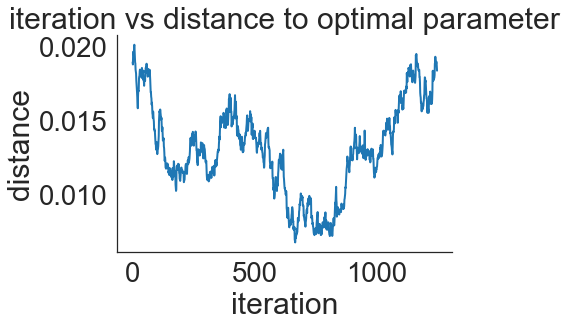

mean   = [ 4.53643799  0.82918538  0.28803068  0.08536261 -0.08049846  0.05238438
 -0.16396317 -0.07391037  0.33672923  0.05898152]
stdevs = [3.16785375 0.67662647 0.96828174 0.93321716 0.97136896 0.94208085
 0.92025973 0.94316091 0.93031298 0.97624208]

mean error             = 0.18
stdev error            = 0.511
||cov error||_2^{1/2}  = 1.28
||true cov||_2^{1/2}   = 3.34



/Users/jhuggins/Desktop/viabel/viabel/bounds.py:191: UserWarning: significant Monte Carlo error when computing ELBO (mean = 6.36636977251916, standard deviation = 0.41728071662318783)
  warn(msg)


Computing CUBO and ELBO with 2500000 samples took 26.705 sec to run

Bounds on...
  2-Wasserstein   36.7
  2-divergence    5.11
  mean error      36.7
  stdev error     36.7
  sqrt cov error  54.1
  cov error       2.93e+03

Results with PSIS correction
----------------------------


/Users/jhuggins/Desktop/viabel/notebooks/psis.py:295: RuntimeWarning: overflow encountered in exp
  np.exp(temp, out=temp)


khat = 0.583

mean   = [ 4.38433493  0.80148931  0.31870002  0.09325799 -0.0829678   0.06041016
 -0.16215176 -0.07249511  0.35652848  0.07990818]
stdevs = [3.3382999  1.17901261 0.9882592  0.93632062 0.96764169 0.94461251
 0.92969304 0.94168817 0.96331912 0.9773765 ]

mean error             = 0.0251
stdev error            = 0.0227
||cov error||_2^{1/2}  = 0.331
||true cov||_2^{1/2}   = 3.34

|---------------|
|     CHIVI     |
|---------------|


Average Loss = 8.2346: 100%|██████████| 5000/5000 [01:27<00:00, 57.22it/s]


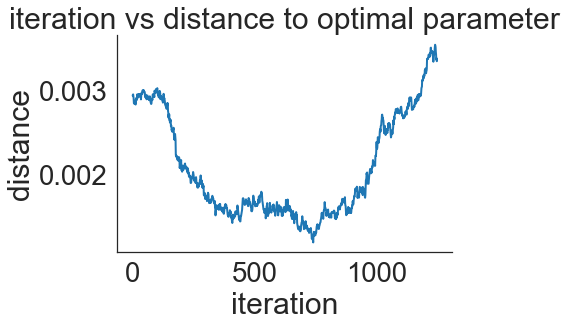

mean   = [ 4.38088176  0.9805771   0.33260403  0.09389412 -0.09530886  0.05950804
 -0.1754611  -0.08778724  0.36946619  0.07578641]
stdevs = [3.5159892  1.2411996  1.05108365 0.9846381  1.01982687 0.98793505
 0.9821266  0.99151629 1.02307385 1.02470631]

mean error             = 0.18
stdev error            = 0.247
||cov error||_2^{1/2}  = 1.28
||true cov||_2^{1/2}   = 3.34

Computing CUBO and ELBO with 2500000 samples took 25.681 sec to run

Bounds on...
  2-Wasserstein   29.3
  2-divergence    3.8
  mean error      29.3
  stdev error     29.3
  sqrt cov error  43.9
  cov error       1.93e+03

Results with PSIS correction
----------------------------


/Users/jhuggins/Desktop/viabel/notebooks/psis.py:295: RuntimeWarning: overflow encountered in exp
  np.exp(temp, out=temp)


khat = 0.402

mean   = [ 4.3954969   0.80405391  0.31819703  0.09640565 -0.08370597  0.06178335
 -0.16003093 -0.07415995  0.3568154   0.07566899]
stdevs = [3.32003461 1.16896937 0.98892614 0.93871605 0.968286   0.94358711
 0.93034721 0.94360702 0.96034577 0.9756625 ]

mean error             = 0.0345
stdev error            = 0.0178
||cov error||_2^{1/2}  = 0.317
||true cov||_2^{1/2}   = 3.34


In [16]:
var_family_ncp_8 = mean_field_t_variational_family(n_params_ncp, 8)
run_experiment(eight_schools_ncp_log_density, var_family_ncp_8, init_param_ncp, true_mean_ncp, true_cov_ncp, 
               learning_rate=.01, learning_rate_end=.001,
               n_iters=5000, bound_w2=2500000, verbose=True);